# Theano, Lasagne
и с чем их едят

# разминка
* напиши на numpy функцию, которая считает сумму квадратов чисел от 0 до N, где N - аргумент
* массив чисел от 0 до N - numpy.arange(N)

In [1]:
!pip install Theano
!pip install lasagne

You are using pip version 8.1.1, however version 9.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.1, however version 9.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np
def sum_squares(N):
    return np.sum(np.square(np.arange(N)))

In [4]:
%%time
sum_squares(10**8)

CPU times: user 653 ms, sys: 1.81 s, total: 2.46 s
Wall time: 3.3 s


662921401752298880

# theano teaser

Как сделать то же самое

In [5]:
import theano
import theano.tensor as T

In [192]:


#будущий параметр функции
N = T.scalar("a dimension",dtype='int32')

inputs = [N, M]


#рецепт получения суммы квадратов
result = N + M

#компиляция функции "сумма квадратов" чисел от 0 до N
sum_function = theano.function(inputs,outputs=result)

NameError: name 'M' is not defined

In [195]:
%%time
sum_function(10**8)

CPU times: user 309 ms, sys: 255 ms, total: 563 ms
Wall time: 562 ms


array(662921401752298880)

# Как оно работает?
* Нужно написать "рецепт" получения выходов по входам
* То же самое на заумном: нужно описать символический граф вычислений


* 2 вида зверей - "входы" и "преобразования"
* Оба могут быть числами, массивами, матрицами, тензорами и т.п.


* Вход - это то аргумент функции. То место, на которое подставится аргумент вызове.
 * N - вход в примере выше


* Преобразования - рецепты вычисления чего-то на основе входов и констант
 * (T.arange(N)^2).sum() - 3 последовательных преобразования N
 * Работают почти 1 в 1 как векторные операции в numpy
 * почти всё, что есть в numpy есть в theano tensor и называется так же
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * и так далее...
   * Совсем редко - бывает, что меняется название или синтаксис - нужно спросить у семинаристов или гугла
 
 
Ничего не понятно? Сейчас исправим.

In [8]:
#входы
example_input_integer = T.scalar("вход - одно число(пример)",dtype='float32')

example_input_tensor = T.tensor4("вход - четырёхмерный тензор(пример)")
#не бойся, тензор нам не пригодится



input_vector = T.vector("вход - вектор целых чисел", dtype='int32')


In [9]:
#преобразования

#поэлементное умножение
double_the_vector = input_vector*2

#поэлементный косинус
elementwise_cosine = T.cos(input_vector)

#разность квадрата каждого элемента и самого элемента
vector_squares = input_vector**2 - input_vector


In [10]:
double_the_vector

Elemwise{mul,no_inplace}.0

In [34]:
#теперь сам:
#создай 2 вектора из чисел float32
my_vector = T.vector("my_vector",dtype='float32')
my_vector2 = T.vector("my_vector2",dtype='float32')

In [35]:
#напиши преобразование, которое считает
#(вектор 1)*(вектор 2) / (sin(вектор 1) +1)
my_transformation = my_vector * my_vector2 / (T.sin(my_vector) + 1)

In [36]:
print my_transformation
#то, что получилась не чиселка - это нормально

Elemwise{true_div,no_inplace}.0


# Компиляция
* До этого момента, мы использовали "символические" переменные
 * писали рецепт вычислений, но ничего не вычисляли
* чтобы рецепт можно было использовать, его нужно скомпилировать

In [37]:
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

# можно скомпилировать написанные нами преобразования как функцию
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [38]:
#можно вызвать вот-так:
print "using python lists:"
print my_function([1,2,3],[4,5,6])
print

#а можно так. 
#К слову, ту тип float приводится к типу второго вектора
print "using numpy arrays:"
print my_function(np.arange(10),
                  np.linspace(5,6,10,dtype='float'))


using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]

using numpy arrays:
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# хинт для отладки
* Если ваша функция большая, компиляция может отнять какое-то время.
* Чтобы не ждать, можно посчитать выражение без компиляции
* Вы экономите время 1 раз на компиляции, но сам код выполняется медленнее


In [39]:
#словарик значений для входов
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

#вычислить без компиляции
#если мы ничего не перепутали, 
#должно получиться точно то же, что и раньше
print my_transformation.eval(my_function_inputs)


#можно вычислять преобразования на ходу
print "сумма 2 векторов", (my_vector + my_vector2).eval(my_function_inputs)

#!ВАЖНО! если преобразование зависит только от части переменных,
#остальные давать не надо
print "форма первого вектора", my_vector.shape.eval({
        my_vector:[1,2,3]
    })


[  2.1721766    5.23752832  15.77397728]
сумма 2 векторов [ 5.  7.  9.]
форма первого вектора [3]


* Для отладки желательно уменьшить масштаб задачи. Если вы планировали послать на вход вектор из 10^9 примеров, пошлите 10~100.
 Если #ОЧЕНЬ нужно послать большой вектор, быстрее скомпилировать функцию обычным способом

# Теперь сам

In [69]:
# Задание 1 - напиши и скомпилируй theano-функцию, которая считает среднеквадратичную ошибку двух векторов-входов
# Вернуть нужно одно число - собственно, ошибку. Обновлять ничего не нужно

vector1 = T.vector("input 1", dtype='float32')
vector2 = T.vector("input 2", dtype='float32')

result = T.sum((vector1 - vector2) ** 2) / T.shape(vector1)

inputs = [vector1, vector2]
outputs = result

compute_mse = theano.function(inputs, result, allow_input_downcast=True)

In [94]:
compute_mse([0, 1], [3, 5])

array([ 12.5])

In [70]:
#тесты
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print 'Wrong result:'
                print 'mse(%s,%s)'%(el,el_2)
                print "should be: %f, but your function returned %f"%(true_mse,my_mse)
                raise ValueError,"Что-то не так"

print "All tests passed"
            
    

All tests passed


# Shared variables

* Входы и преобразования - части рецепта. 
 * Они существуют только во время вызова функции.


* Shared переменные - всегда остаются в памяти
 * им можно поменять значение 
   * (но не внутри символического графа. Об этом позже)
 * их можно включить в граф вычислений
 
 
* хинт - в таких переменных удобно хранить параметры и гиперпараметры
 * например, веса нейронки или learning rate, если вы его меняете

In [71]:
#cоздадим расшаренную перменную
shared_vector_1 = theano.shared(np.ones(10,dtype='float64'))

In [72]:

#получить (численное) значение переменной
print "initial value",shared_vector_1.get_value()

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [73]:
#задать новое значение
shared_vector_1.set_value( np.arange(5) )

#проверим значение
print "new value", shared_vector_1.get_value()

#Заметь, что раньше это был вектор из 10 элементов, а сейчас - из 5. 
#Если граф при этом остался выполним, это сработает.

new value [ 0.  1.  2.  3.  4.]


# Теперь сам

In [75]:
#напиши рецепт (преобразование), которое считает произведение(поэллементное) shared_vector на input_scalar
#скомпилируй это в функцию от input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

scalar_times_shared = input_scalar * shared_vector_1


shared_times_n = theano.function([input_scalar], scalar_times_shared)


In [76]:
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)",shared_times_n(5)

print "shared_times_n(-0.5)",shared_times_n(-0.5)


shared: [ 0.  1.  2.  3.  4.]
shared_times_n(5) [  0.   5.  10.  15.  20.]
shared_times_n(-0.5) [-0.  -0.5 -1.  -1.5 -2. ]


In [77]:
#поменяем значение shared_vector_1
shared_vector_1.set_value([-1,0,1])
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)",shared_times_n(5)

print "shared_times_n(-0.5)",shared_times_n(-0.5)


shared: [-1.  0.  1.]
shared_times_n(5) [-5.  0.  5.]
shared_times_n(-0.5) [ 0.5 -0.  -0.5]


# T.grad, самое вкусное
* theano умеет само считать производные. Все, которые существуют.
* Производные считаются в символическом, а не численном виде

Ограничения
* За раз можно считать производную __скалярной__ функции по одной или нескольким скалярным или векторным аргументам
* Функция должна на всех этапах своего вычисления иметь тип float32 или float64 (т.к. на множестве целых чисел производная не имеет смысл)

In [78]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#производная v_squared по my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative) 

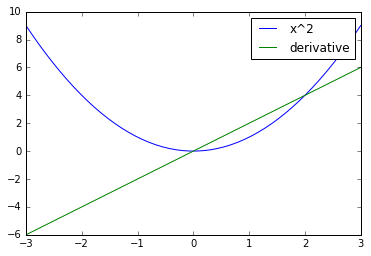

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(-3,3)
x_squared = map(fun,x)
x_squared_der = map(grad,x)

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# теперь сам

In [93]:
two_d_vector = T.vectors('float32')
result = 2 * two_d_vector
compute = theano.function([two_d_vector], result)

TypeError: __init__() takes at least 3 arguments (2 given)

In [92]:
compute([[0, 1], [2, 3]])

TypeError: ('Bad input argument to theano function with name "<ipython-input-91-b04d53e62ecd>:3"  at index 0(0-based)', 'Wrong number of dimensions: expected 1, got 2 with shape (2, 2).')

In [80]:

my_vector = T.vector('float64')

#посчитай производные этой функции по my_scalar и my_vector
#warning! Не пытайся понять физический смысл этой функции
weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar,der_by_vector = T.grad(weird_psychotic_function, my_scalar), T.grad(weird_psychotic_function, my_vector)


compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)


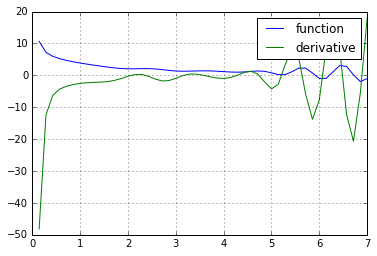

In [81]:
#график функции и твоей производной
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()


# Последний штрих - Updates

* updates - это способ изменять значения shared переменных каждый раз В КОНЦЕ вызова функции

* фактически, это словарь {shared_переменная: рецепт нового значения}, который добавляется в функцию при компиляции

Например,

In [83]:
#умножим shared вектор на число и сохраним новое значение обратно в этот shared вектор

inputs = [input_scalar]
outputs = [scalar_times_shared] #вернём вектор, умноженный на число

my_updates = {
    shared_vector_1:scalar_times_shared #и этот же результат запишем в shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [84]:
shared_vector_1.set_value(np.arange(5))

#изначальное значение shared_vector_1
print "initial shared value:" ,shared_vector_1.get_value()

# теперь вычислим функцию (значение shared_vector_1 при этом поменяется)
print "compute_and_save(2) returns",compute_and_save(2)

#проверим, что в shared_vector_1
print "new shared value:" ,shared_vector_1.get_value()



initial shared value: [ 0.  1.  2.  3.  4.]
compute_and_save(2) returns [array([ 0.,  2.,  4.,  6.,  8.])]
new shared value: [ 0.  2.  4.  6.  8.]


# Логистическая регрессия
Что нам потребуется:
* Веса лучше хранить в shared-переменной
* Данные можно передавать как input
* Нужно 2 функции:
 * train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту __(через updates)__
 * predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [85]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target


print "y [форма - %s]:"%(str(y.shape)),y[:10]

print "X [форма - %s]:"%(str(X.shape))
print X[:3]

y [форма - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [форма - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [182]:
# переменные и входы
shared_weights = theano.shared(np.random.uniform(size=X.shape[1]))
input_X = T.matrix('features', dtype='float32')
input_y = T.vector('labels', dtype='float32')

In [183]:
predicted_y = 1. / (1. + T.exp(-T.dot(input_X, shared_weights)))
loss = -T.sum(input_y * T.log(predicted_y) + (1 - input_y) * T.log(1 - predicted_y))

grad = T.grad(loss, shared_weights)

lr = 0.01

updates = {
    shared_weights: shared_weights - lr * grad
}

In [184]:
train_function = theano.function([input_X, input_y], loss, updates=updates, allow_input_downcast=True)
predict_function = theano.function([input_X], predicted_y, allow_input_downcast=True)

In [185]:
predict_function(X_test[:10])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [186]:
y_test[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1])

In [187]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

loss at iter 0:22909.1847
train auc: 0.5
test auc: 0.5
loss at iter 1:409134.3370
train auc: 0.996212121212
test auc: 1.0
loss at iter 2:148.6230
train auc: 0.996212121212
test auc: 1.0
loss at iter 3:111.4830
train auc: 0.996212121212
test auc: 1.0
loss at iter 4:74.3430
train auc: 0.996212121212
test auc: 1.0
resulting weights:


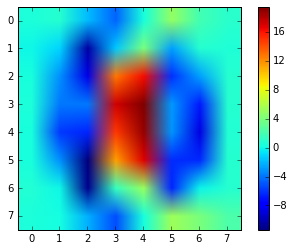

In [188]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train,y_train)
    print "loss at iter %i:%.4f"%(i,loss_i)
    print "train auc:",roc_auc_score(y_train,predict_function(X_train))
    print "test auc:",roc_auc_score(y_test,predict_function(X_test))

    
print "resulting weights:"
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()

In [189]:
predict_function(X_test[:10])

array([  1.00000000e+000,   0.00000000e+000,   1.00000000e+000,
         1.94947261e-271,   1.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   1.00000000e+000,   0.00000000e+000,
         1.00000000e+000])

In [190]:
y_test[:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1])